In [ ]:
#INSTALLATIONS
!pip install imageio==2.19.3
!pip install imageio-ffmpeg
!pip install tweepy
!pip install requests redis requests_oauthlib flask
!pip install selenium
!pip install snscrape

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 20.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 15.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were

In [ ]:
from requests_oauthlib import OAuth1Session
import os
import json

class TwitterAPI:
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret):
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret

    def auth(self):
        consumer_key = self.consumer_key
        consumer_secret = self.consumer_secret

        # Get request token
        request_token_url = "https://api.twitter.com/oauth/request_token?oauth_callback=oob&x_auth_access_type=write"
        self.oauth = OAuth1Session(consumer_key, client_secret=consumer_secret)

        try:
            fetch_response = self.oauth.fetch_request_token(request_token_url)
        except ValueError:
            print(
                "There may have been an issue with the consumer_key or consumer_secret you entered."
            )

        resource_owner_key = fetch_response.get("oauth_token")
        resource_owner_secret = fetch_response.get("oauth_token_secret")
        #print("Got OAuth token: %s" % resource_owner_key)

        # Get authorization
        base_authorization_url = "https://api.twitter.com/oauth/authorize"
        authorization_url = self.oauth.authorization_url(base_authorization_url)

        access_token = self.access_token
        access_token_secret = self.access_token_secret

        # Make the request
        self.oauth = OAuth1Session(
            consumer_key,
            client_secret=consumer_secret,
            resource_owner_key=access_token,
            resource_owner_secret=access_token_secret,
        )

    def post(self, tweet, in_reply_to_status_id=None, media_ids=None, geo=None, poll=None, quote_tweet_id=None, reply=None, reply_settings=None):
        if hasattr(self, 'oauth'):
            url = 'https://api.twitter.com/2/tweets'

            payload = {"text": tweet}

            # Add additional features if provided
            if in_reply_to_status_id:
                payload["reply"] = {"in_reply_to_tweet_id": in_reply_to_status_id}
            if media_ids:
                payload["media"] = {"media_ids": media_ids}
            if geo:
                payload["geo"] = {"place_id": geo}
            if poll:
                payload["poll"] = poll
            if quote_tweet_id:
                payload["quote_tweet_id"] = quote_tweet_id
            if reply:
                payload["reply"] = reply
            if reply_settings:
                payload["reply_settings"] = reply_settings

            response = self.oauth.post(url, json=payload)

            if response.status_code != 201:
                raise Exception(
                    "Request returned an error: {} {}".format(response.status_code, response.text)
                )
            else:
                print("[Tweet publicado con éxito]")

            # Saving the response as JSON
            json_response = response.json()
            # Return the tweet ID
            return json_response["data"]["id"]
        else:
            print("Usuario non autorizado")
            return None


    def upload_image(self, file_path):
        if hasattr(self, 'oauth'):
            url = 'https://upload.twitter.com/1.1/media/upload.json'
            with open(file_path, 'rb') as f:
                files = {'media': f.read()}
            req = self.oauth.post(url, files=files)
            if req.status_code != 200:
                raise Exception(
                    'Media upload failed: {}'.format(req.text)
                )
            else:
                print("[Imaxe subida correctamente]")
            media_id = req.json()['media_id_string']
            return media_id
        else:
            print("Usuario non autorizado")


In [ ]:
twitter = TwitterAPI("Eda7ozqmOLKqBfnPZKWnFE6pd", 
                     "3ws9mxCJxyf97bTsoRKViwzplUPDjhLNEvMe2lGDhNZt2by5uL",
                     "1665178569042022400-3tUUzNqDImzSfBU9429yzBbwqrAkT2",
                     "zfX5e4YB74BQJB6Ysvwhcf3CdZll0lYJOGzgzBRQU2RPS")

In [ ]:
#IMPORTS
import time
import random
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import pandas as pd
import json
from PIL import Image, ImageFont, ImageDraw
import imageio.v2 as imageio
import requests
from requests.structures import CaseInsensitiveDict
from requests_oauthlib import OAuth1Session
import os

In [ ]:
def replace_and_concord(s):

    # Reemplazar 'por o' y 'por a'
    s = s.replace(' por o ', ' polo ')
    s = s.replace(' por a ', ' pola ')
    s = s.replace(' por os ', ' polos ')
    s = s.replace(' por as ', ' polas ')

    # Partir la cadena en partes relevantes
    inicio, resto = s.split('conquista', 1)
    articulo_y, final = resto.split(', antes controlad', 1)

    genero = 'a'
    numero = ''

    # Determinar el género y el número de Y a partir del artículo
    if len(articulo_y.split()) > 1:
        if ' ' in articulo_y:
            articulo, y = articulo_y.strip().split(' ', 1)
        else:
            articulo = articulo_y.strip()
        if articulo in ['o', 'os']:
            genero = 'o'
        if articulo in ['as', 'os']:
            numero = 's'

    # Reconstruir la cadena con la concordancia correcta
    s = inicio + 'conquista' + articulo_y + ', antes controlad' + genero + numero + final[1:]

    return s

def contraerLugares(s):
    s = s.replace(" en o ", " no ")
    s = s.replace(" en a ", " na ")
    return s

def capitalize(cadea):
    if not cadea:
        return ""
    primeira_letra = cadea[0].upper()
    resto_da_cadea = cadea[1:]
    return primeira_letra + resto_da_cadea

In [ ]:
#FUNCTIONS


class UscWarbot:

    def __init__(self, mapaUrl, mapaRefUrl, facUrl, facRefUrl, infoUrl):
        self.mapaUrl = mapaUrl
        self.mapaRefUrl = mapaRefUrl
        self.facUrl = facUrl
        self.facRefUrl = facRefUrl
        self.infoUrl = infoUrl
        self.loadFiles()

    def restore(self):
        mapaRef = gpd.read_file(self.mapaRefUrl)
        facultadesRef = json.load(open(self.facRefUrl))
        with open(self.facUrl, 'w') as outfile:
            json.dump(facultadesRef, outfile, indent=4)
            mapaRef.to_file(self.mapaUrl, driver="GeoJSON")
        info = json.load(open('data/genData.json'))
        info['date'] = {"month":1, "year":2027}
        with open('data/genData.json', 'w') as outfile:
                    json.dump(info, outfile, indent=4)
        url = "https://api.npoint.io/f4b38e6409af19b299ea"
        headers = CaseInsensitiveDict()
        headers = {
            "Accept": "application/json",
            "Content-Type": "application/json"
        }

        data = self.mapa.drop(columns='punto_medio').to_crs(epsg=4326).to_json()
        resp = requests.post(url, headers=headers, data=data)

        urlFacultades = " https://api.npoint.io/6f81e2e0dd2000746eb4"
        dataFac = json.dumps(self.facultades)
        resp = requests.post(urlFacultades, headers=headers, data=dataFac)

        with open('data/webInfoRef.json', 'r') as file:
            web_info_ref = json.load(file)

        # Save the updated content back to data/webInfo.json
        with open('data/webInfo.json', 'w') as file:
            json.dump(web_info_ref, file, indent=4)

        print("[Xogo reiniciado correctamente]")


    def loadFiles(self, primeira=False):
        self.mapa = gpd.read_file(self.mapaUrl).to_crs(4326)
        self.mapa = self.mapa.assign(punto_medio=self.mapa.geometry.apply(lambda row: row.centroid))
        self.mapa = self.mapa.assign(fac_inicial=self.mapa['facultade'])
        self.mapa = self.mapa.assign(line_width=0.35)
        self.facultades = json.load(open('data/facultades.json'))
        self.info = json.load(open(self.infoUrl))
        mapaRef = gpd.read_file(self.mapaRefUrl)
        self.mapa = self.mapa.assign(fac_orixinal=mapaRef['facultade'])
        self.mapa = self.mapa.assign(foi_capital=mapaRef['type'])
            


    def checkFacultades(self, prints=False):
        areas = {}
        for facultade in self.facultades:
            n = 0
            for i, rexion, in enumerate(self.mapa['facultade']):
                if rexion == facultade['id']:
                    if prints:
                        print(f"   - {mapa['nome'][i]}")
                    n +=1
            areas[facultade['nome']] = n
            if(prints):
                print(f"{facultade['nome']} controla {n} áreas")

    def selectZonas(self, nivel=0):
        mapa = self.mapa
        if nivel > 250:
            return None, None
        r1 = mapa.loc[random.randint(0,len(self.mapa)-1)]
        while r1['facultade'] == 'null':
            r1 = mapa.loc[random.randint(0,len(mapa)-1)]

        vecinhas = [int(x) for x in r1['vecinhas'].split(",")]
        r2 = mapa.loc[vecinhas[random.randint(0,len(vecinhas)-1)]]
        n = 0
        while r1['facultade'] == r2['facultade'] or (r1['type'] == 'capital' and r2['type'] == 'capital'):
            r2 = mapa.loc[vecinhas[random.randint(0,len(vecinhas)-1)]]
            n += 1
            if n > 10:
                return self.selectZonas(nivel+1)
        self.r1 = r1
        self.r2 = r2
        return r1, r2
    
    def isOver(self):
        return self.r1 is None

    def firstDay(self):
        with open('data/webInfo.json', 'r') as file:
            web_info = json.load(file)
        return web_info["numeroDias"]==0
    
    def getZona(self, index):
        return self.mapa['facultade'][index]
    
    def getFacultade(self,zona,inicial=False):
        for i,fac in enumerate(self.facultades):
            if inicial:
                if fac['id'] == zona['fac_inicial']:
                    return fac
            if fac['id'] == zona['facultade']:
                return fac
        return None

    def tamFac(self,facultade):
        n = 0
        for i, rexion, in enumerate(self.mapa['facultade']):
            if rexion == facultade['id']:
                n +=1
        return n
    
    def isDestroyed(self,facultade):
        return self.tamFac(facultade) == 0

    def updateMapa(self):
        self.mapa.loc[self.rlos['id'], 'facultade'] = self.fwin['id']
        self.mapa.at[self.rlos['id'], 'stroke'] = self.fwin['cor']
        self.mapa.at[self.rlos['id'], 'type'] = 'normal'
        self.mapa.at[self.rlos['id'], 'fill-opacity'] = 0.3
        if self.fwin['rebBool'] == 1:
            self.mapa.at[self.rlos['id'], 'fullnome'] = self.fwin['rebelde'][2:]
        else:
            self.mapa.at[self.rlos['id'], 'fullnome'] = self.fwin['nome'][2:]
        for facultade in self.facultades:
            facultade['nRexions'] = self.tamFac(facultade)

    def poder(self,facultade):
        if facultade['id'] == 'null':
            return 0
        return self.tamFac(facultade)*9 + facultade['exp']


    def fightZonas(self,f1,f2):
        n = 1
        c1, c2 = 1,1
        reb1, reb2 = 2, 2
        if self.r1['type'] == 'capital':
            c1 = 5
        if self.r2['type'] == 'capital':
            c2 = 5
        if f1['rebBool'] == 1:
            reb1 = 1
        if f2['rebBool'] == 1:
            reb2 = 1

        num = random.randint(0,c1*reb1*self.poder(f1) + c2*reb2*self.poder(f2))

        if num < c1*reb1*self.poder(f1):
            self.rwin = self.r1
            self.fwin = f1
            self.rlos = self.r2
            self.flos = f2
        else:
            self.rwin = self.r2
            self.fwin = f2
            self.rlos = self.r1
            self.flos = f1
        
        for n in range(0, 132):
            zona = self.mapa.loc[n]
            if n == self.rlos['id']:
                self.mapa.loc[n, 'line-width'] = 0.8
            elif zona['type'] == 'capital':
                self.mapa.loc[n, 'fill-opacity'] = 0.7
                self.mapa.loc[n, 'line-width'] = 0.9
            elif self.getFacultade(zona) == f1 or self.getFacultade(zona) == f2:
                self.mapa.loc[n, 'fill-opacity'] = 0.5
                self.mapa.loc[n, 'line-width'] = 0.35
            else:
                self.mapa.loc[n, 'fill-opacity'] = 0.1
                self.mapa.loc[n, 'line-width'] = 0.3

        if self.isDestroyed(self.flos):
            for n in range(0, 132):
                if self.mapa.loc[n, 'facultade'] == self.flos['id']:
                    self.mapa.loc[n, 'facultade'] = self.fwin['id']
                    self.mapa.loc[n, 'stroke'] = self.fwin['cor']
                    self.mapa.loc[n, 'type'] = 'normal'
                    self.mapa.loc[n, 'fill-opacity'] = 0.3
                    self.mapa.loc[n, 'fullnome'] = self.rwin['fullnome']
            return f". {self.flos['nome']} foi destruida.", n
        return "", n

    def plotearMapa(self):
        mapa = self.mapa
        plt.clf()
        fig,self.ax = plt.subplots()
        bordes = mapa.plot(color='none', edgecolor=mapa['stroke'], linewidth=mapa['line-width'], ax=self.ax)
        fotomapa = mapa.plot(color=mapa['fill'], alpha=mapa['fill-opacity'], edgecolor='none', ax=self.ax)

        fotomapa.set_facecolor('#696969')
        bordes.set_facecolor('none')

    def increaseExp(self,facultade):
        self.facultades[facultade['num']]['exp'] += 1
    
    def renderizar(self,f1,f2):
        for i, alpha_area in enumerate(self.mapa['fill-opacity']):
            if pd.isna(alpha_area):
                self.mapa.at[i, 'fill-opacity'] = 1

        for i, area in enumerate(self.mapa['fill']):
            if area is None:
                self.mapa.at[i, 'fill'] = '#F0F0F0'
            else:
                area = area.upper()

        for i, area in enumerate(self.mapa['stroke']):
            area = area.upper()

        self.plotearMapa()
        plt.axis('off')
        #self.pintarNodos()
        plt.savefig("mapa.png", dpi=503, transparent=True)
        background = Image.open("base_lowres.png")

        foreground = Image.open("mapa.png")
        background.paste(foreground, (-818, -302), foreground)
        background.save("mapa.png")

        x = abs(self.rlos['punto_medio'].x + 8.570915)*1920/0.047318
        y = abs(self.rlos['punto_medio'].y - 42.894560)*1920/0.033563
                
        img = background
        zoom = background.crop((x-200, y-200, x+200, y+200)).resize((300,300))

        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("Fonts/Montserrat-Bold.ttf", 30)

        s = 2
        x = toPng(self.getPos(f1))[0]
        y = toPng(self.getPos(f1))[1]

        draw.text((x-s, y-s), f1['label'], font=font, fill="black")
        draw.text((x+s, y-s), f1['label'], font=font, fill="black")
        draw.text((x-s, y+s), f1['label'], font=font, fill="black")
        draw.text((x+s, y+s), f1['label'], font=font, fill="black")

        draw.text((x,y),f1['label'],(255,255,255),font=font)

        x = toPng(self.getPos(f2))[0]
        y = toPng(self.getPos(f2))[1]
        #print(f'X: {x}, Y: {y}')
        #print(f"Text: {f1['label']}")

        draw.text((x-s, y-s), f2['label'], font=font, fill="black")
        draw.text((x+s, y-s), f2['label'], font=font, fill="black")
        draw.text((x-s, y+s), f2['label'], font=font, fill="black")
        draw.text((x+s, y+s), f2['label'], font=font, fill="black")

        draw.text((x,y),f2['label'],(255,255,255),font=font)

        new_width = 1480
        new_height = 1480
        background_reduced = background.resize((new_width, new_height))

        background_reduced.save("mapa.png")
        zoom.save('mapa_zoom.png')

        zoom.close()
        background.close()
        foreground.close()
        plt.close()

    def normalStyle(self):
        self.mapa.at[self.rlos['id'], 'fill'] = self.fwin['cor']
        for n in range(0,132):
            zona = self.mapa.loc[n]
            if zona['type'] == 'capital':
                self.mapa.at[n, 'fill-opacity'] = 0.7
                self.mapa.at[n, 'line-width'] = 0.9
            else:
                self.mapa.at[n, 'fill-opacity'] = 0.2
                self.mapa.at[n, 'line-width'] = 0.3
    
    def saveTurno(self, tweet):
        if(not self.firstDay()):
            self.info = self.nextDate()
            self.mapa.drop(columns=['punto_medio','fac_inicial', 'line-width']).to_file(self.mapaUrl, driver="GeoJSON")
            with open(self.infoUrl, 'w') as outfile:
                json.dump(self.info, outfile, indent=4)

            with open(self.facUrl, 'w') as outfile:
                json.dump(self.facultades, outfile, indent=4)
            
            invader = ""
            invaderFac = {}
            for i, fac in enumerate(self.facultades):
                if fac['rebBool'] == 1:
                    for n, orixinal in enumerate(self.mapa['fac_orixinal']):
                        zona = self.mapa.loc[n]
                        if (zona['foi_capital'] == 'capital') and (zona['fac_orixinal'] == fac['id']):
                            invader = zona['facultade']
                            break
                    for fac2 in self.facultades:
                        if fac2['id'] == invader:
                            invaderFac = fac2
                            break
                    for n in range(0,132):
                        zona = self.mapa.loc[n]
                        if zona['facultade'] == fac['id']:
                            self.mapa.loc[n, 'stroke'] = invaderFac['cor']
                            self.mapa.at[n, 'fill-opacity'] = 0.3

        url = "https://api.npoint.io/f4b38e6409af19b299ea"
        headers = {
            "Accept": "application/json",
            "Content-Type": "application/json"
        }

        data = self.mapa.drop(columns='punto_medio').to_crs(epsg=4326).to_json()
        resp = requests.post(url, headers=headers, data=data)

            # Add the JSON data to the list in web_info
            #geojson_object = json.loads(data)  # Convert the string back to a JSON object

            # Post the JSON object for Facultades to the given endpoint
        urlFacultades = "https://api.npoint.io/6f81e2e0dd2000746eb4"
        dataFac = json.dumps(self.facultades)
        resp = requests.post(urlFacultades, headers=headers, data=dataFac)

        lista_facultades = self.mapa['facultade'].tolist()
        assert len(lista_facultades) == 133

            # Leer el archivo JSON (si existe), o inicializar un diccionario con estructura básica
        try:
            with open("data/webInfo.json", 'r') as f:
                data = json.load(f)
        except FileNotFoundError:
            data = {
                "numeroDias": 0,  # puedes cambiar este valor por defecto si es necesario
                "configuracion": []
            }

        # Añadir la lista de facultades al diccionario
        data["configuracion"].append(lista_facultades)
        data["tweets"].append(tweet)
        data["numeroDias"] += 1

        #LOAD WebInfo JSON

        urlWebInfo = "https://api.npoint.io/19526cf66896452287d1"
        headers = {
            "Accept": "application/json",
            "Content-Type": "application/json"
        }
        resp = requests.post(urlWebInfo, headers=headers, data=json.dumps(data))
        
        with open("data/webInfo.json", 'w') as f:
            json.dump(data, f, indent=4)



    def nextDate(self):
        if self.info['date']['month'] + 1 > 12:
            return {'date':{'month':1,'year':self.info['date']['year'] + 1}}
        return {'date':{'month':self.info['date']['month']+1,'year':self.info['date']['year']}}
            
    def getPos(self,facultade):
        x = 0
        y = 0
        n = 0
        for z in range(0,len(self.mapa)):
            if self.mapa['facultade'][z] == facultade['id']:
                x += self.mapa['punto_medio'][z].x
                y += self.mapa['punto_medio'][z].y
                n += 1
        if n == 0:
            return (self.rlos['punto_medio'].x,self.rlos['punto_medio'].y)
        return (x/n,y/n)
    
    def getMonth(self):
        meses = ["Xaneiro","Febreiro","Marzo","Abril","Maio","Xuño","Xullo","Agosto","Setembro","Outubro","Novembro","Decembro"]
        return meses[self.info['date']['month']-1]

    def pintarNodos(self):
        line_strings = []
        points = []
        for n in range(0,len(self.mapa)-1):
            vecinhas = self.mapa.loc[n]['vecinhas']
            if type(vecinhas) == type("") and not(vecinhas == '')and not(vecinhas == 'null'):
                for i in [int(x) for x in vecinhas.split(",")]:
                    line_strings.append(LineString([self.mapa['punto_medio'][n],self.mapa['punto_medio'][i]]))
            points.append(self.mapa['punto_medio'][n])

        geom = line_strings + points
        gdf = gpd.GeoDataFrame(geometry=geom)
        gdf.plot(ax=self.ax, color = 'white', markersize=1.25, linewidth=0.3)


    def checkNodos(self):
        for facultade in self.facultades:
            n = 0
            for i, rexion, in enumerate(self.mapa['vecinhas']):
                if self.mapa['facultade'][i] == facultade['id']:
                    print(f"   - {self.mapa['nome'][i]}: {len([int(x) for x in rexion.split(',')])} nodos")
                    n += len([int(x) for x in rexion.split(",")])
        #print(f"{facultade['nome']} controla {n} nodos")


def ancho(text, font):
    im1 = Image.new('RGBA', (1000, 1000), (255, 255, 255, 0))
    img = ImageDraw.Draw(im1)
    fonte = font
    w = img.textsize(text, font=fonte)[0]
    return w

def centrar(pos, text, fonte, img):
    return (img.width / 2 - ancho(text, fonte) // 2 + pos[0], pos[1])



def toPng(pos):
    return (abs(pos[0] + 8.570915)*1920/0.047318, abs(pos[1] - 42.894560)*1920/0.033563)





In [ ]:
uscW = UscWarbot('data/mapa.geojson',
                    'data/mapaRef.geojson',
                    'data/facultades.json',
                    'data/facultades_ref.json',
                    'data/genData.json')


In [ ]:
def subirTweet(tweet, fotos, response=None):
    twitter = TwitterAPI("Eda7ozqmOLKqBfnPZKWnFE6pd", 
                     "3ws9mxCJxyf97bTsoRKViwzplUPDjhLNEvMe2lGDhNZt2by5uL",
                     "1665178569042022400-3tUUzNqDImzSfBU9429yzBbwqrAkT2",
                     "zfX5e4YB74BQJB6Ysvwhcf3CdZll0lYJOGzgzBRQU2RPS")
    twitter.auth()
    id = None
    if(fotos):
        mapa_id = twitter.upload_image("mapa.png")
        mapa_zoom_id = twitter.upload_image("mapa_zoom.png")
        id = twitter.post(tweet, in_reply_to_status_id=response, media_ids=[mapa_id, mapa_zoom_id])
    else:
        id = twitter.post(tweet, in_reply_to_status_id=response)

    return id


In [ ]:

def turno(iteration, renderizar=True, publicar=False):

    uscW = UscWarbot('data/mapa.geojson',
                    'data/mapaRef.geojson',
                    'data/facultades.json',
                    'data/facultades_ref.json',
                    'data/genData.json')

    
    uscW.selectZonas()
    fotos = True

    if(iteration != 0 and iteration % 13 == 0):
        sorted_facs = []
        sorted_facs = sorted(uscW.facultades, key=lambda facultade: facultade['nRexions'], reverse=True)
        sorted_facs = [facultade for facultade in sorted_facs if facultade['id'] != "null"]

        tweet = "Top 5 Facultades:\n"
        tweet2 = "Facultades Derrotadas:\n"
        tweet3 = ""
        for i in range(1,6):
            facultade = sorted_facs[i-1]
            if i==1:
                tweet += "🥇 "
            elif i==2:
                tweet += "🥈 "
            elif i==3:
                tweet += "🥉 "
            else:
                tweet += f" {i}. "
            tweet += f"{facultade['label']}"
            if facultade['nRexions'] == 0:
                tweet += " (💀)\n"
            else:
                tweet += f" ({facultade['nRexions']})\n"

        facs2 = [facultade for facultade in sorted_facs if facultade['nRexions'] == 0]
        facs3 = []
        if len(sorted_facs) == 0:
            tweet2 += "[Ningunha facultade foi derrotada]"
        if len(facs2) > 11:
            metade = len(facs2) // 2
            facs2 = facs2[:metade]
            facs3 = facs2[metade:]

        for facultade in facs2:
            tweet2 += f"💀 {facultade['label']}\n"
        for facultade in facs3:
            tweet3 += f"💀 {facultade['label']}\n"

        if(publicar):
            id = subirTweet(tweet, False)
            id = subirTweet(tweet2, False, response=id)
            if tweet3 != "":
                id = subirTweet(tweet3, False, response=id)
            subirTweet("Consulta o mapa interactivo en: https://usc-warbot.netlify.app/", False, response=id)
    else:
        if uscW.firstDay():
            tweet = "Ano 2026. O planeta enteiro faleceu a causa dunha nova pandemia letal. Todo? Non, a alcaldesa dunha pequena aldea galega, Compostela, logrou elaborar un antídoto, convertindo esta cidade no único remanso de humanidade restante... A causa do caos desencadeado, o goberno local terminou caendo e as distintas facultades pelexan agora polo control da cidade..."
        else:
            if uscW.isOver():
                winner = uscW.getFacultade(uscW.getZona(0))
                tweet = f"{winner['nome']} conseguiu o control total de Compostela e proclámase vencedora da I guerra da USC"

            else:
                f1, f2 = uscW.getFacultade(uscW.r1), uscW.getFacultade(uscW.r2)
                rexionsQuitadas = 1

                facInicial = uscW.getFacultade(uscW.r1, inicial=True)
                extra = uscW.fightZonas(f1,f2)
                if(uscW.fwin['rebBool']==0):
                    nomeW = uscW.fwin['nome']
                else:
                    nomeW = uscW.fwin['rebelde'] + f" ({uscW.fwin['label']})"
                if(uscW.flos['rebBool']==0):
                    nomeL = uscW.flos['nome']
                else:
                    nomeL = uscW.flos['rebelde'] + f" ({uscW.flos['label']})"
                tweet = f"{capitalize(nomeW)} conquista {uscW.rlos['nome']}, antes controlada por {nomeL}. "+ extra[0]
                tweet = replace_and_concord(tweet)

                if uscW.rlos['foi_capital'] == "capital":
                    if uscW.rlos['fac_orixinal'] == uscW.flos['id']:
                        uscW.flos['rebBool'] = 1
                        for i, rexion, in enumerate(uscW.mapa['facultade']):
                            if rexion == uscW.flos['id']:
                                uscW.mapa.loc[i, 'fullnome'] = uscW.flos['rebelde'][2:]
                                if random.randint(1,3) <= 1:
                                    uscW.mapa.loc[i, 'facultade'] = uscW.fwin['id']
                                    uscW.mapa.at[i, 'stroke'] = uscW.fwin['cor']
                                    uscW.mapa.at[i, 'type'] = 'normal'
                                    uscW.mapa.at[i, 'fill-opacity'] = 0.3
                                    if uscW.fwin['rebBool'] == 1:
                                        uscW.mapa.at[i, 'fullnome'] = uscW.fwin['rebelde'][2:]
                                    else:
                                        uscW.mapa.at[i, 'fullnome'] = uscW.fwin['nome'][2:]
                        for facultade in uscW.facultades:
                            facultade['nRexions'] = uscW.tamFac(facultade)
                        if uscW.flos['nRexions'] - rexionsQuitadas != 0:
                            tweet += f"Pese a que o seu goberno foi tumbado, fórmase {uscW.flos['rebelde']}, un movemento de resistencia á forza invasora."
                    if uscW.rlos['fac_orixinal'] == uscW.fwin['id']:
                        tweet += f"{capitalize(uscW.fwin['rebelde'])} recupera o control do seu goberno, voltando a ser {uscW.fwin['nome']}. "
                        for facultade in uscW.facultades:
                            if facultade['id'] == uscW.flos['id']:
                                facultade['rebBool'] = 0
                        for i, rexion, in enumerate(uscW.mapa['fullnome']):
                            if rexion == uscW.rwin['fullnome']:
                                uscW.mapa.loc[i, 'fullnome'] = uscW.fwin['nome'][2:]
                if uscW.flos['nRexions'] - rexionsQuitadas == 0:
                    tweet += f"\n{capitalize(uscW.flos['nome'])} foi derrotada. "
                elif uscW.flos['nRexions'] - rexionsQuitadas == 1:
                    for i, rexion  in enumerate(uscW.mapa['facultade']):
                        if rexion == uscW.flos['id'] and uscW.mapa.at[i, 'nome'] != uscW.rlos['nome']:
                            if uscW.flos['rebBool'] == 1:
                                resiste = f"\n{capitalize(uscW.flos['rebelde'])} atrinchéirase en {uscW.mapa.at[i, 'nome']}. "
                            else:
                                resiste = f"\n{capitalize(uscW.flos['nome'])} atrinchéirase en {uscW.mapa.at[i, 'nome']}. "
                            tweet += contraerLugares(resiste)

                uscW.updateMapa()
                if uscW.flos['id'] != 'null':
                    uscW.increaseExp(uscW.fwin)

                if renderizar:
                    uscW.renderizar(f1,f2)
                uscW.normalStyle()
            tweet = uscW.getMonth() + " de " + str(uscW.info['date']['year']) + ": " + tweet
        uscW.saveTurno(tweet)

        if(publicar):
            id = subirTweet(tweet, fotos)
            subirTweet("Consulta o mapa interactivo en: https://usc-warbot.netlify.app/", False, response=id)

    return tweet


In [ ]:
#RESTORE GAME
uscW.restore()

[Xogo reiniciado correctamente]


In [ ]:
tweets = []
for i in range(13,14):
    print(turno(i, renderizar=True, publicar=True))
print("\n------------------------------------------------\n")

Exception: Request returned an error: 429 {"title":"Too Many Requests","detail":"Too Many Requests","type":"about:blank","status":429}

{'a Facultade de Farmacia': 0, 'a Facultade de Matemáticas': 0, 'a Facultade de Bioloxía': 0, 'a ETSE': 0, 'a Facultade de Psicoloxía': 0, 'a Facultade de Química': 0, 'a Facultade de Dereito': 0, 'a Facultade de Física': 0, 'a Facultade de CC Políticas e Sociais': 0, 'a Facultade de Relacións Laborais': 0, 'a Facultade de CC Económicas e Empresariais': 0, 'a Facultade de Óptica e Optometría': 0, 'a Facultade de Xeografía e Historia': 0, 'a Facultade de Filosofía': 0, 'a Facultade de Filoloxía': 0, 'a Facultade de CC da Comunicación': 0, 'a Facultade de Medicina e Odontoloxía': 0, 'a Facultade de Enfermería': 0, 'a Facultade de CC da Educación': 0, 'o Mundo Libre': 0}
Proba 0:
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


NameError: name 'simulaPartida' is not defined

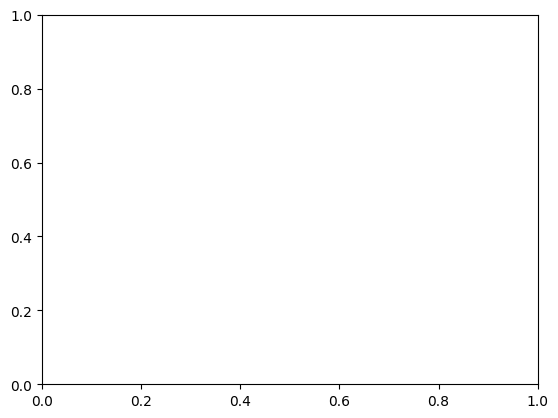

In [ ]:
#MAIN

facultades = json.load(open('data/facultades.json'))

ganhadores = {}
for facultade in facultades:
    ganhadores[facultade['nome']] = 0

print(ganhadores)

for proba in range(0,1):
    print(f"Proba {proba}:")
    mapa = gpd.read_file('data/mapa.geojson')
    mapa['punto_medio'] = mapa.geometry.centroid
    mapa['fac_inicial'] = mapa['facultade']
    mapa['fac_orixinal'] = mapa['facultade']
    facultades = json.load(open('data/facultades.json'))

    fig,ax=plt.subplots()
    w = simulaPartida(mapa,facultades,renderizar=True)
    ganhadores[w] += 1
    plt.close()
    if proba%25 == 0:
        print(ganhadores)

print(ganhadores)
plt.xticks(rotation='vertical')
plt.bar(ganhadores.keys(), ganhadores.values(), 1, color='blue')

In [ ]:
from PIL import Image

filenames = ["frames/frame" + str(volta) + ".png"for volta in range(400,480)]
images = []
for index,volta in enumerate(range(400,480)):
    filename = filenames[index]
    if volta%10 == 0:
        print("")
        print(f"{volta}: ", end='')
    print(f"|",end='')
    background = Image.open("base_lowres.png")
    foreground = Image.open("frames/frame" + str(volta) + ".png")
    background.paste(foreground, (-1055, -302), foreground)
    background.save("frames_def/frame" + str(volta) + ".png")
    images.append(imageio.imread("frames_def/frame" + str(volta) + ".png"))
    background.close()
    foreground.close()
imageio.mimsave('anim5.mp4', images, fps=5)


400: |

FileNotFoundError: [Errno 2] No such file or directory: 'frames/frame400.png'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=199b7abd-c421-4d96-b841-399c6fbfee0b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>